# Algos Clasificación: Regresión Logística

## Ejemplo con statsmodels (via seaborn)

In [1]:
import seaborn as sns
sns.set(font_scale = 1.5 , style="white", rc={'figure.dpi':80})

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np

fast, slow = 40,200
data = yf.download('AAPL', auto_adjust=True, start='2010-01-01')
data['GAP'] = (data.Open / data.Close.shift() - 1)*100
data['Trend'] = np.where(data.Close > data.Close.rolling(100).mean(), 'Bull', 'Bear')
data['Mov Intra'] = (data.Close/data.Open -1)*100
data['Suba Intra'] = np.where(data.Close > data.Open, 1, 0)
data = data.dropna()
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,GAP,Trend,Mov Intra,Suba Intra
Date,,,,,,,,,
2010-01-05,6.590541,6.620944,6.549081,6.583784,601904800,0.275676,Bear,-0.102519,0
2010-01-06,6.583784,6.609889,6.472304,6.479061,552160000,0.000005,Bear,-1.590632,0
2010-01-07,6.503014,6.510692,6.420095,6.467082,477131200,0.369705,Bear,-0.552545,0
2010-01-08,6.458484,6.510693,6.420403,6.510078,447610800,-0.132953,Bear,0.798858,1
2010-01-11,6.535262,6.541404,6.401670,6.452650,462229600,0.386841,Bear,-1.264089,0
...,...,...,...,...,...,...,...,...,...
2021-06-21,130.300003,132.410004,129.210007,132.300003,79663300,-0.122646,Bull,1.534919,1
2021-06-22,132.130005,134.080002,131.619995,133.979996,74783600,-0.128494,Bull,1.400129,1
2021-06-23,133.770004,134.320007,133.229996,133.699997,60214200,-0.156733,Bull,-0.052334,0


## Regresion lineal

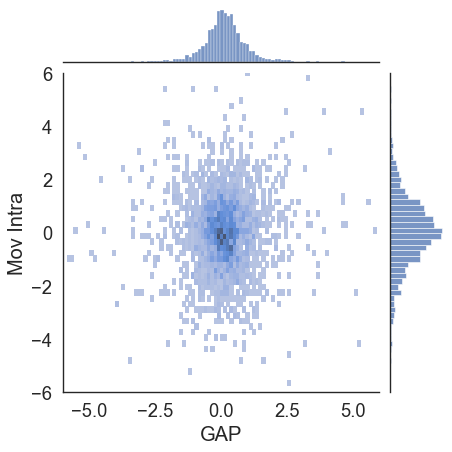

In [3]:
sns.jointplot(data=data, x='GAP', y='Mov Intra', xlim=(-6,6), ylim=(-6,6), kind="hist")

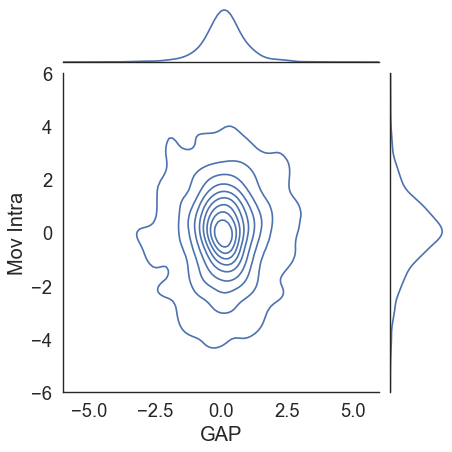

In [4]:
sns.jointplot(data=data, x='GAP', y='Mov Intra', xlim=(-6,6), ylim=(-6,6), kind="kde")

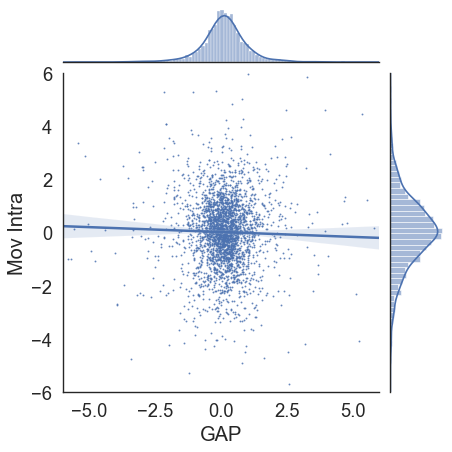

In [5]:
sns.jointplot(data=data, x='GAP', y='Mov Intra', xlim=(-6,6), ylim=(-6,6), kind="reg", marker='.', scatter_kws={'s':2})

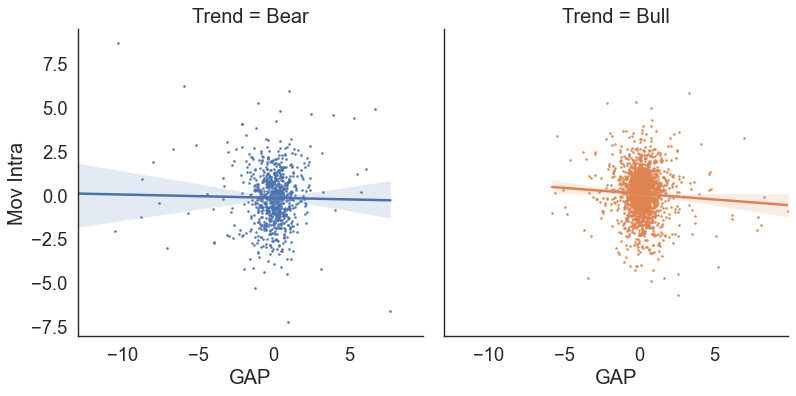

In [6]:
sns.lmplot(data=data, x='GAP', y='Mov Intra', col='Trend', hue='Trend', scatter_kws={'s':2})

## Regresion Logistica

### Modelo

$$ {\Large \log _{e}{\frac {p}{1-p}}=\beta _{0}+\beta _{1}x_{1} + .... + \beta _{i}x_{i}} $$

$$  {\Large p(x)=\sigma (t)={\frac {1}{1+e^{-(\beta _{0} +\beta _{1}x)}}}} $$ 

### Supuestos

Debe chequearse que:

* No hay multicolinealidad
* Independencia de errores (no-autocorrelacion)


No pasa naranja con:
    
* Linealidad (ya que la variable dependiente va a ser categórica)
* Normalidad de los residuos
* Homocedasticidad

In [7]:
from sympy import *

In [8]:
t , ft = symbols('t,ft')

In [9]:
ft = 1/(1+E**(-t))

In [10]:
ft

1/(1 + exp(-t))

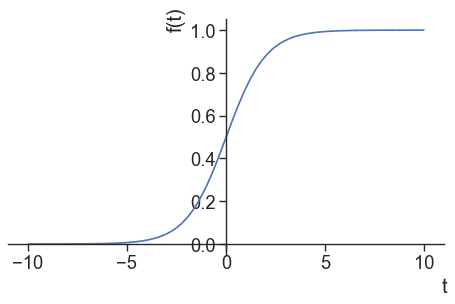

In [11]:
plot(ft)

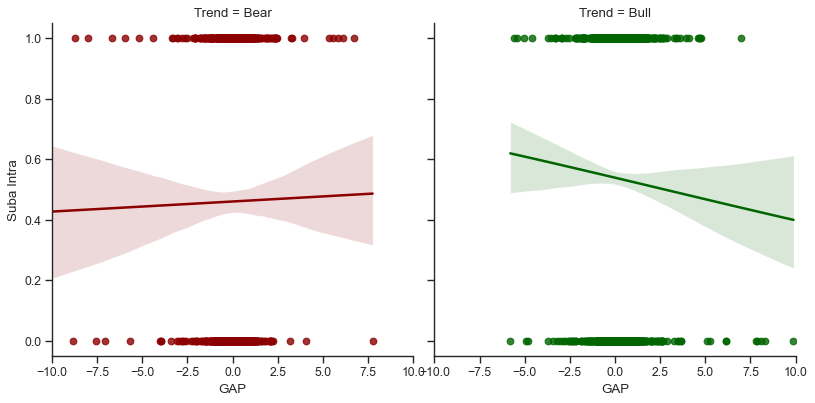

In [12]:
sns.set_theme(style="ticks")

g = sns.lmplot(x="GAP", y="Suba Intra", col="Trend", hue="Trend", data=data, 
                palette=['darkred','darkgreen'], logistic=True)

g.set(xlim=(-10, 10), ylim=(-.05, 1.05))

## Ejemplo con sklearn

### Preparo los datos

In [3]:
import matplotlib.pyplot as plt

import yfinance as yf
import pandas as pd
import numpy as np

In [18]:
medias = ((63, 422), (38, 350), (72, 506))
ventana = 100

data = yf.download('GGAL', start='2000-01-01')

dif = data['Adj Close'].diff()
win = pd.DataFrame(np.where(dif > 0, dif, 0))
loss = pd.DataFrame(np.where(dif < 0, abs(dif), 0))
ema_win = win.ewm(alpha=1/14).mean()
ema_loss = loss.ewm(alpha=1/14).mean()
rs = ema_win / ema_loss
rsi = 100 - (100 / (1 + rs))
rsi.index = data.index

data['pctChange'] = data['Adj Close'].pct_change()
data['fw'] = data['Adj Close'].shift(-ventana)/data['Adj Close']-1
data['rsi'] = rsi/100
data['roll_vol'] = data['pctChange'].rolling(60).std() * 60**0.5
data['ema_vol'] = data['pctChange'].ewm(span=300).std() * 300**0.5
data['cruce_1'] = data['Adj Close'].rolling(medias[0][0]).mean()/data['Adj Close'].rolling(medias[0][1]).mean()-1
data['cruce_2'] = data['Adj Close'].rolling(medias[1][0]).mean()/data['Adj Close'].rolling(medias[1][1]).mean()-1
data['cruce_3'] = data['Adj Close'].rolling(medias[2][0]).mean()/data['Adj Close'].rolling(medias[2][1]).mean()-1

data['target'] = 0
data.loc[data.fw >= 0 , 'target'] = 1

data_full = data.copy() # Esto nos va a servir despues cuando necesitemos los de hoy (sin etiquetas aun)
data = data.round(4).dropna()

y = list(data['target'])
X = data.iloc[:,-7:-1]

X

[*********************100%***********************]  1 of 1 completed


,rsi,roll_vol,ema_vol,cruce_1,cruce_2,cruce_3
Date,,,,,,
2002-08-01,0.5164,1.2248,2.0035,-0.9164,-0.9198,-0.9182
2002-08-02,0.5164,1.2248,1.9966,-0.9173,-0.9188,-0.9191
2002-08-05,0.5064,1.2245,1.9898,-0.9183,-0.9177,-0.9198
2002-08-06,0.4863,1.2221,1.9834,-0.9193,-0.9163,-0.9204
2002-08-07,0.4863,1.2220,1.9766,-0.9202,-0.9148,-0.9211
...,...,...,...,...,...,...
2021-02-01,0.4691,0.2655,0.8119,-0.3767,-0.1942,-0.4823
2021-02-02,0.4550,0.2658,0.8093,-0.3729,-0.1963,-0.4797
2021-02-03,0.4550,0.2564,0.8066,-0.3700,-0.1979,-0.4768


### Separamos los datos de entrenamiento de los de validación

In [8]:
from sklearn.model_selection import train_test_split

# Entrenamos con el 40% de los datos al modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [9]:
X_test[:5]

,rsi,roll_vol,ema_vol,cruce_1,cruce_2,cruce_3
Date,,,,,,
2018-07-30,0.4493,0.3229,0.5357,-0.0990,-0.2335,0.0197
2003-08-28,0.5073,0.2722,1.6297,1.0489,1.0387,0.5059
2016-05-02,0.5275,0.1696,0.4801,0.3552,0.2733,0.4188
2012-08-30,0.5397,0.2000,0.5322,-0.5050,-0.4311,-0.5294
2017-12-28,0.6953,0.1576,0.3576,0.5100,0.4946,0.5517


### Escalamos los datos... ojo acá

In [20]:
from sklearn.preprocessing import StandardScaler
escalar = StandardScaler()

X_train = escalar.fit_transform(X_train)
X_test = escalar.fit_transform(X_test)

# Esto es para luego poder usar los datos actuales (sin fw)
X_full = data_full.iloc[:,-7:-1].dropna()
X_full_escalado = escalar.fit_transform(X_full)

In [16]:
X_test[:5].round(4)

array([[-0.5459,  0.1331, -0.3697, -0.3857, -0.7226, -0.1347],
       [-0.0957, -0.053 ,  1.6976,  2.1184,  2.2064,  0.8306],
       [ 0.061 , -0.4294, -0.4748,  0.6051,  0.4442,  0.6577],
       [ 0.1557, -0.3179, -0.3763, -1.2713, -1.1776, -1.2248],
       [ 1.3634, -0.4735, -0.7063,  0.9428,  0.9537,  0.9215]])

### Importamos el modelo

In [23]:
from sklearn.linear_model import LogisticRegression
modelo = LogisticRegression()

### Entrenamiento

In [24]:
modelo.fit(X_train, y_train)

LogisticRegression()

### Corremos el modelo

In [25]:
y_pred = modelo.predict(X_test)
y_pred

array([0, 1, 1, ..., 0, 0, 1])

In [26]:
pd.DataFrame(y_pred).groupby(0).size()

0
0     777
1    1088
dtype: int64

### Obtenemos las predicciones de probabilidad 

In [27]:
modelo.predict_proba(X_test)

array([[0.59244582, 0.40755418],
       [0.01785825, 0.98214175],
       [0.48708616, 0.51291384],
       ...,
       [0.50033674, 0.49966326],
       [0.54832341, 0.45167659],
       [0.49417283, 0.50582717]])

### Matriz de Confusión

In [28]:
# Importamos el modelo de matriz de donfusion
from sklearn.metrics import confusion_matrix

m = np.array(confusion_matrix(y_test, y_pred, normalize='all')).round(2)

matriz = {'manteca':m[1][1], 'mike oscilator':m[1][0],'all in':m[0][1], 'yo te avise':m[0][0]}

resumen = {'aciertos' : f"{matriz['manteca']+matriz['yo te avise']:.2%}", 
           'sesgo +': f"{matriz['manteca']+matriz['all in']:.1%}"}

print('Regresion Logistica: \n',m,'\nPorcentajes:\n',matriz,'\n',resumen)

Regresion Logistica: 
 [[0.22 0.21]
 [0.2  0.37]] 
Porcentajes:
 {'manteca': 0.37, 'mike oscilator': 0.2, 'all in': 0.21, 'yo te avise': 0.22} 
 {'aciertos': '59.00%', 'sesgo +': '58.0%'}


### Vemos predicción de algún valor

In [29]:
datosHoy = X_full_escalado[-1]
datosHoy

array([-0.95675855, -0.29236911, -0.10538572, -0.45397165, -0.11044092,
       -0.72875251])

In [30]:
modelo.predict((datosHoy,))

array([1])

In [31]:
modelo.predict_proba((datosHoy,))

array([[0.32732016, 0.67267984]])

In [32]:
ultimos = X_full_escalado[-5:]
prediccion_ultimos = modelo.predict(ultimos)
print('\nPrediccion Ultimos 5 valores actuales\n',prediccion_ultimos)


Prediccion Ultimos 5 valores actuales
 [1 1 1 1 1]


In [33]:
ultimos = X_full_escalado[-5:]
prediccion_ultimos = modelo.predict_proba(ultimos)
print('\nPrediccion Ultimos 5 valores actuales\n',prediccion_ultimos)


Prediccion Ultimos 5 valores actuales
 [[0.30312646 0.69687354]
 [0.3114527  0.6885473 ]
 [0.31384076 0.68615924]
 [0.32221842 0.67778158]
 [0.32732016 0.67267984]]


<AxesSubplot:xlabel='Date'>

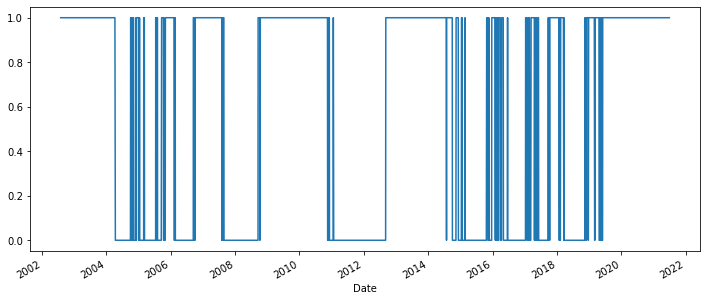

In [34]:
predicciones = [x for x in modelo.predict(X_full_escalado)]
pd.Series(predicciones, index=X_full.index).plot(figsize=(12,5))

<AxesSubplot:xlabel='Date'>

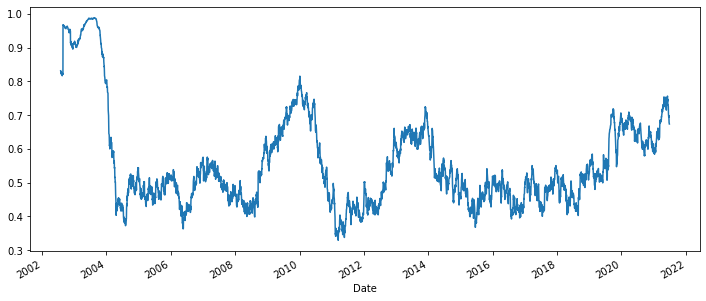

In [19]:
predicciones = [x[1] for x in modelo.predict_proba(X_full_escalado)]
pd.Series(predicciones, index=X_full.index).plot(figsize=(12,5))

Reflexión:

¿Que le ven de diferente a la salida del Arbol de Decisión?

<img src="imagenes/pr_arboles.png" width=800>

<img src="imagenes/pr_reglog.png" width=800>

# Algos Clasificación: Vectores de Soporte (SVM)

## Concepto de kernel no lineal, ejemplo radial

<br>
<img src="imagenes/svm_a.png" style="float:left;width:220px">
<img src="imagenes/svm_b.png" style="float:left;width:220px;margin-left:50px">
<img src="imagenes/svm_c.png" style="float:left;width:220px;margin-left:50px">

<br>

In [35]:
from sympy import *

x,y = symbols('x,y')

c = (x+1)**2 + y**2

In [36]:
c

y**2 + (x + 1)**2

In [37]:
eq_r1 = Eq(c,1)
eq_r1

Eq(y**2 + (x + 1)**2, 1)

In [39]:
eq_r3 = Eq(c,9)
eq_r3

Eq(y**2 + (x + 1)**2, 9)

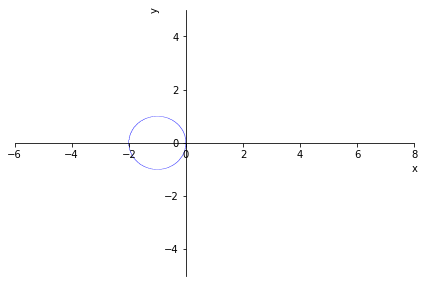

In [40]:
plot_implicit(eq_r1, (x,-6,8))

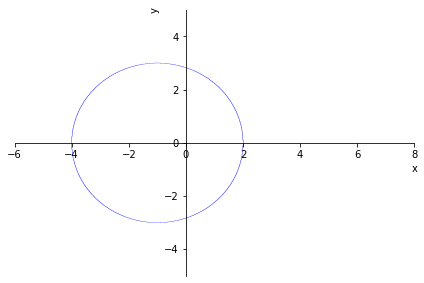

In [41]:
plot_implicit(eq_r3, (x,-6,8))

<IPython.core.display.Javascript object>


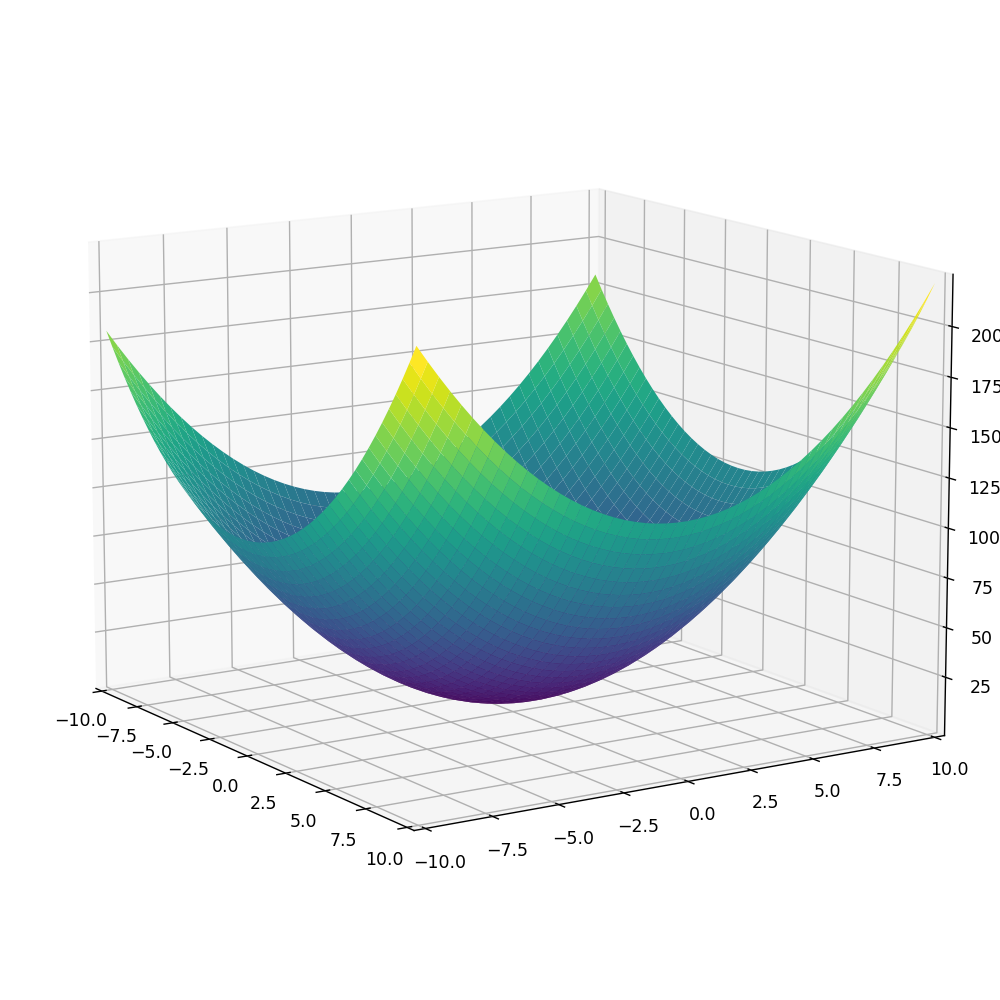

In [42]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 8,8

plotting.plot3d(c)

<img src='imagenes/svm_1.png'>

## Concepto de los vectores de soporte

<img src='imagenes/svm_2.ppm'>

## Lo corremos todo de una

In [43]:
import yfinance as yf, numpy as np, pandas as pd

medias = ((63, 422), (38, 350), (72, 506))
ventana = 100

data = yf.download('GGAL', start='2000-01-01')

dif = data['Adj Close'].diff()
win = pd.DataFrame(np.where(dif > 0, dif, 0))
loss = pd.DataFrame(np.where(dif < 0, abs(dif), 0))
ema_win = win.ewm(alpha=1/14).mean()
ema_loss = loss.ewm(alpha=1/14).mean()
rs = ema_win / ema_loss
rsi = 100 - (100 / (1 + rs))
rsi.index = data.index

data['pctChange'] = data['Adj Close'].pct_change()
data['fw'] = data['Adj Close'].shift(-ventana)/data['Adj Close']-1
data['rsi'] = rsi/100
data['roll_vol'] = data['pctChange'].rolling(60).std() * 60**0.5
data['ema_vol'] = data['pctChange'].ewm(span=300).std() * 300**0.5
data['cruce_1'] = data['Adj Close'].rolling(medias[0][0]).mean()/data['Adj Close'].rolling(medias[0][1]).mean()-1
data['cruce_2'] = data['Adj Close'].rolling(medias[1][0]).mean()/data['Adj Close'].rolling(medias[1][1]).mean()-1
data['cruce_3'] = data['Adj Close'].rolling(medias[2][0]).mean()/data['Adj Close'].rolling(medias[2][1]).mean()-1

data['target'] = 0
data.loc[data.fw >= 0 , 'target'] = 1

data_full = data.copy() # Esto nos va a servir despues cuando necesitemos los de hoy (sin etiquetas aun)
data = data.round(4).dropna()

y = list(data['target'])
X = data.iloc[:,-7:-1]


from sklearn.model_selection import train_test_split

# Entrenamos con el 50% de los datos al modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)


# Para escalar los datos para que pesen similar en la formula
from sklearn.preprocessing import StandardScaler
escalar = StandardScaler()

X_train = escalar.fit_transform(X_train)
X_test = escalar.fit_transform(X_test)

# Esto es para luego poder usar los datos actuales (sin fw)
X_full = data_full.iloc[:,-7:-1].dropna()
X_full_escalado = escalar.fit_transform(X_full)


# Importamos el modelo
from sklearn.svm import SVC

modelo = SVC(kernel = 'rbf', gamma=12, probability=True)
#  kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}, default='rbf'
# "rbf" es una función de base radial que depende de "gamma" que se puede pasar en el constructor
# Otro parámetro es C que es el grado de rigurosidad de los datos entre los soportes
# Otro parámetro es degree que es el grado en caso de usar kernels polinomicos


# Entrenamiento
modelo.fit(X_train, y_train)

# predicciones
y_pred = modelo.predict(X_test)

# Importamos el modelo de matriz positivos y negativos
from sklearn.metrics import confusion_matrix

m = np.array(confusion_matrix(y_test, y_pred, normalize='all')).round(2)

matriz = {'manteca':m[1][1], 'mike oscilator':m[1][0],'all in':m[0][1], 'yo te avise':m[0][0]}

resumen = {'aciertos' : f"{matriz['manteca']+matriz['yo te avise']:.1%}", 
           'sesgo +': f"{matriz['manteca']+matriz['all in']:.1%}"}

print('Support Vector Machine: \n',m,'\nPorcentajes:\n',matriz,'\n',resumen)

ultimos = X_full_escalado[-5:]


prediccion_ultimos = modelo.predict(ultimos)
print('\nPrediccion Ultimos 5 valores actuales\n',prediccion_ultimos)

[*********************100%***********************]  1 of 1 completed
Support Vector Machine: 
 [[0.38 0.06]
 [0.03 0.53]] 
Porcentajes:
 {'manteca': 0.53, 'mike oscilator': 0.03, 'all in': 0.06, 'yo te avise': 0.38} 
 {'aciertos': '91.0%', 'sesgo +': '59.0%'}

Prediccion Ultimos 5 valores actuales
 [1 0 0 1 1]


<AxesSubplot:xlabel='Date'>

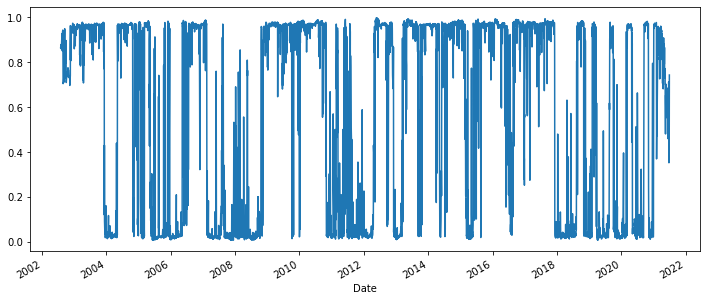

In [46]:
%matplotlib inline

probas = [x[1] for x in modelo.predict_proba(X_full_escalado)]
pd.Series(probas, index=X_full.index).plot(figsize=(12,5))

Reflexion:
    
    
¿y ahora?

<img src="imagenes/pr_arboles.png" width=800>

<img src="imagenes/pr_reglog.png" width=800>

<img src="imagenes/pr_svm_1.png" width=800>

<img src="imagenes/pr_svm_2.png" width=800>

# Algos de Clasifiación: Bosques aleatorios

<img src='imagenes/bosques_1.png' width='600'>

In [56]:
import yfinance as yf, numpy as np, pandas as pd

medias = ((63, 422), (38, 350), (72, 506))
ventana = 100

data = yf.download('GGAL', start='2000-01-01')

dif = data['Adj Close'].diff()
win = pd.DataFrame(np.where(dif > 0, dif, 0))
loss = pd.DataFrame(np.where(dif < 0, abs(dif), 0))
ema_win = win.ewm(alpha=1/14).mean()
ema_loss = loss.ewm(alpha=1/14).mean()
rs = ema_win / ema_loss
rsi = 100 - (100 / (1 + rs))
rsi.index = data.index

data['pctChange'] = data['Adj Close'].pct_change()
data['fw'] = data['Adj Close'].shift(-ventana)/data['Adj Close']-1
data['rsi'] = rsi/100
data['roll_vol'] = data['pctChange'].rolling(60).std() * 60**0.5
data['ema_vol'] = data['pctChange'].ewm(span=300).std() * 300**0.5
data['cruce_1'] = data['Adj Close'].rolling(medias[0][0]).mean()/data['Adj Close'].rolling(medias[0][1]).mean()-1
data['cruce_2'] = data['Adj Close'].rolling(medias[1][0]).mean()/data['Adj Close'].rolling(medias[1][1]).mean()-1
data['cruce_3'] = data['Adj Close'].rolling(medias[2][0]).mean()/data['Adj Close'].rolling(medias[2][1]).mean()-1

data['target'] = 0
data.loc[data.fw >= 0 , 'target'] = 1

data_full = data.copy() # Esto nos va a servir despues cuando necesitemos los de hoy (sin etiquetas aun)
data = data.round(4).dropna()

y = list(data['target'])
X = data.iloc[:,-7:-1]


from sklearn.model_selection import train_test_split

# Entrenamos con el 50% de los datos al modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)


# Para escalar los datos para que pesen similar en la formula
from sklearn.preprocessing import StandardScaler
escalar = StandardScaler()

X_train = escalar.fit_transform(X_train)
X_test = escalar.fit_transform(X_test)

# Esto es para luego poder usar los datos actuales (sin fw)
X_full = data_full.iloc[:,-7:-1].dropna()
X_full_escalado = escalar.fit_transform(X_full)


# Importamos el modelo
from sklearn.ensemble import RandomForestClassifier

# Invocamos la constructor
modelo = RandomForestClassifier(criterion = 'entropy', max_depth=6, n_estimators=1000, n_jobs=20) 

# Entrenamiento
modelo.fit(X_train, y_train)

# predicciones
y_pred = modelo.predict(X_test)

# Importamos el modelo de matriz positivos y negativos
from sklearn.metrics import confusion_matrix


m = np.array(confusion_matrix(y_test, y_pred, normalize='all')).round(2)

matriz = {'manteca':m[1][1], 'mike oscilator':m[1][0],'all in':m[0][1], 'yo te avise':m[0][0]}

resumen = {'aciertos' : f"{matriz['manteca']+matriz['yo te avise']:.1%}", 
           'sesgo +': f"{matriz['manteca']+matriz['all in']:.1%}"}


print('Bosques Aleatorios Machine: \n',m,'\nPorcentajes:\n',matriz,'\n',resumen)

ultimos = X_full_escalado[-5:]


# Predecimos resultdos ultimos 5 dias
prediccion_ultimos = modelo.predict(ultimos)
print('\nPrediccion Ultimos 5 valores actuales\n',prediccion_ultimos)


# Predecimos probabilidades ultimos 5 dias
prediccion_ultimos = modelo.predict_proba(ultimos)
print('\nPrediccion Ultimos 5 valores actuales\n',prediccion_ultimos)

[*********************100%***********************]  1 of 1 completed
Bosques Aleatorios Machine: 
 [[0.3  0.14]
 [0.08 0.49]] 
Porcentajes:
 {'manteca': 0.49, 'mike oscilator': 0.08, 'all in': 0.14, 'yo te avise': 0.3} 
 {'aciertos': '79.0%', 'sesgo +': '63.0%'}

Prediccion Ultimos 5 valores actuales
 [1 1 1 1 1]

Prediccion Ultimos 5 valores actuales
 [[0.43716397 0.56283603]
 [0.4573953  0.5426047 ]
 [0.45917262 0.54082738]
 [0.45990956 0.54009044]
 [0.45687038 0.54312962]]


<img src="imagenes/pr_arboles.png" width=800>

<img src="imagenes/pr_reglog.png" width=800>

<img src="imagenes/pr_svm_1.png" width=800>

<img src="imagenes/pr_svm_2.png" width=800>

<img src="imagenes/pr_bosques_aleatorios.png" width=800>

<AxesSubplot:xlabel='Date'>

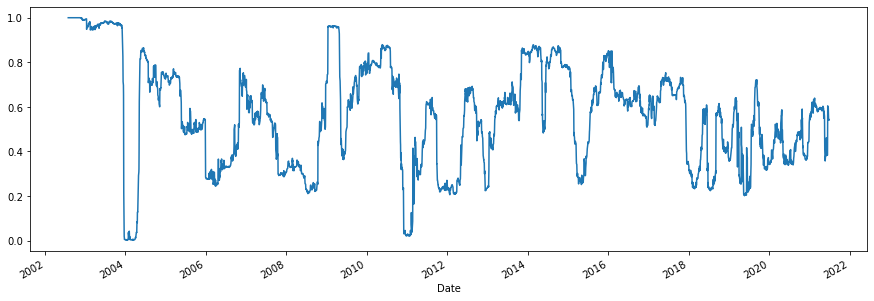

In [62]:
pd.Series([x[1] for x in modelo.predict_proba(X_full_escalado)], index=X_full.index).plot(figsize=(15,5))


# Métricas de modelos predictivos

* Positivos Totales =   Positivos detectados + Falsos negativos

* Negativos Totales =   Negativos detectados + Falsos positivos


* Sensibilidad = Positivos detectados / Positivos Totales
    * Es la probabilidad de que un positivo efectivamente sea pronosticado positivo


* Especificidad = Negativos detectados / Negativos Totales
    * Es la probabilidad de que un negativo efectivamente sea pronosticado negativo


* Exactitud (Accuracy) = Mediciones Correctas / Totales


* Precision = Positivos detectados / (Positivos detectados + Falsos Positivos)


* F1 score = 2 * Precision * Sensibilidad / (Precision + Sensibilidad)



In [64]:
import sklearn.metrics as skm

# Exactitud
skm.accuracy_score(y_test, y_pred)

0.7846417846417847

In [31]:
# Precision
skm.precision_score(y_test, y_pred)

0.7844940867279895

In [32]:
# Sensibilidad
skm.recall_score(y_test, y_pred)

0.9066059225512528

In [33]:
# F1 Score
skm.f1_score(y_test, y_pred)

0.8411412469179289

In [34]:
result  = skm.classification_report(y_test, y_pred, target_names=['Bigote','Manteca'])
print(result)

              precision    recall  f1-score   support

      Bigote       0.85      0.68      0.75      1013
     Manteca       0.78      0.91      0.84      1317

    accuracy                           0.81      2330
   macro avg       0.82      0.79      0.80      2330
weighted avg       0.81      0.81      0.80      2330



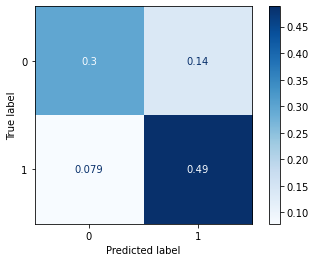

In [69]:
skm.plot_confusion_matrix(modelo, X_test, y_test, normalize='all', cmap='Blues')

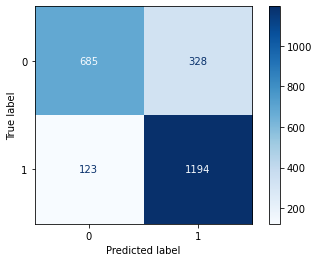

In [36]:
skm.plot_confusion_matrix(modelo, X_test, y_test, cmap='Blues')

# Reporting visual de los resultados (casero)

## Gráfico propio para ver últimas predicciones vs reales caso a caso

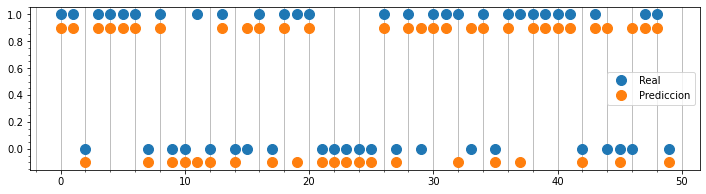

In [70]:
real = np.array(y_test[-50:])
pred = np.array(y_pred[-50:])

fig, ax = plt.subplots(figsize=(12,3))

ax.plot(real, lw=0, markersize=10, marker='o', label='Real')
ax.plot(pred-0.1, lw=0, markersize=10, marker='o', label='Prediccion')

plt.minorticks_on()
ax.grid(which='both', axis='x')

plt.legend()
plt.show()

## Gráfico para ver especificamente los pifies

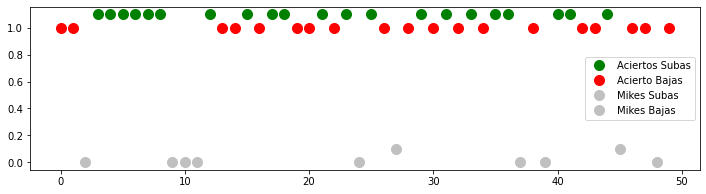

In [38]:
aciertos_bajas = np.where((real==pred) & (real==0), 1,np.nan)
aciertos_subas = np.where((real==pred) & (real==1), 1,np.nan)

mikes_bajas = np.where((real!=pred) & (real==0), 0,np.nan)
mikes_subas = np.where((real!=pred) & (real==1), 0,np.nan)


fig, ax = plt.subplots(figsize=(12,3))
ax.plot(aciertos_subas+0.1, lw=0, markersize=10, marker='o', color='green', label='Aciertos Subas')
ax.plot(aciertos_bajas, lw=0, markersize=10, marker='o', color='red', label='Acierto Bajas')

ax.plot(mikes_subas+0.1, lw=0, markersize=10, marker='o', color='silver', label='Mikes Subas')
ax.plot(mikes_bajas, lw=0, markersize=10, marker='o', color='silver', label='Mikes Bajas')

plt.legend()
plt.show()

# Predictores

Que tipo de predictores usarían para una clasificación para trading?

Trend Following:
    
    * Osciladores con medias moviles tipo RSI, ADX
    * Cruces de medias puros
    * MACD? por que no?
    
    
Contrarians:

    * Outliers en gral de cualquier otro indicador de tendencia (ej. Bollinger)
    
    
Indicadores de Volumen:

    * Cualquier incorporación del vol al precio tipo OBV
    * Indicador de volumen puro
    
    
Indicadores Estadísticos

    * Indicadores parampetricos de la distribución:
        * Desvío estandar
        * kurtosis
        * skew
        * mu
        * ratio de información
    * Zscores de cualquier indicador de las series anteriores
    * Fiteo de parámetros de otras dist
    * Betas o Ratios de correlación:
        * Entre subyacentes
        * Entre indicadores
    
    
Construcción de indicadores propios:

    * Conteos discretos
    * Ajustes precio/volumen (Ej. RSI ajustado por zscore de volumen)
    * Ajustes de indicador por parámetro (Cruce 20/50 ajustado por sigma)
    
    
Indicadores de benchmarks

    * Mercado de referencia
    * Commodities/monedas
    * Indicadores macro de economía
    * Benchamark sectoriales (ej ETF de misma industria)
    * Otros subyacentes similares (misma industria, mismo cluster... veremos mas adelante en algos de clusterizacion)
    

Indicadores de sentiment
    
    * Comentarios en twitter, conteo de menciones, hashtags, conteo de keywords
    * Seguimiento de "cuentas referentes" en redes
    * Menciones en grupos de telegram
    * Otras redes sociales, medios de información


Otras Mediciones externas
    
    * Clima
    * Tránsito
    * Info deportiva
    * Info de vuelos 
    * mediciones concretas de un comercio (tickets, kpis de campañas, etc)

In [ ]:
db.to_sql(con=sql_conn, name='prueba_tabla2', if_exists="append")
OperationalError: (pymysql.err.OperationalError) (1050, "Table 'prueba_tabla2' already exists")

    
sql_conn.execute()
query = "SHOW tables"

# Aprendizaje NO supervisado

## Algos de Agrupamiento

INPUT = <img src='imagenes/clase_16_paradigmas_tot.png' width="480">

OUTPUT =

<img src='imagenes/clase_16_paradigmas_a.png' width="480" style="float:left;border: 1px solid #000">
<img src='imagenes/clase_16_paradigmas_b.png' width="480"  style="float:left;border: 1px solid #000"">

<img src='imagenes/velas.png'>

## Modelado del DataSet

In [39]:
import yfinance as yf
import numpy as np

data = yf.download('GGAL', auto_adjust=True)

data['Avg'] = (data.Open + data.Close + data.High + data.Low)/4
data['Body'] = 100 * abs(data.Close - data.Open) / data.Avg
data['Tot'] = 100 * (data.High-data.Low) / data.Avg
data['Type'] = np.where(data.Close > data.Open, 1 , np.where( data.Close < data.Open, -1, 0))
# faltarian el gap, las mechas inf y sup

# Anteriores
data['Body_bw'] = data['Body'].shift(1)
data['Tot_bw'] = data['Tot'].shift(1)
data['Type_bw'] = data['Type'].shift(1)

# posteriores
data['Body_fw'] = data['Body'].shift(-1)
data['Tot_fw'] = data['Tot'].shift(-1)
data['Type_fw'] = data['Type'].shift(-1)

data = data.drop(['Open','High','Low','Close','Volume'], axis=1)
data = data.dropna()
data

[*********************100%***********************]  1 of 1 completed


,Avg,Body,Tot,Type,Body_bw,Tot_bw,Type_bw,Body_fw,Tot_fw,Type_fw
Date,,,,,,,,,,
2000-07-26,15.918845,1.438849,2.158273,1,0.089948,5.756690,1.0,0.000000,1.428571,0.0
2000-07-27,16.033369,0.000000,1.428571,0,1.438849,2.158273,1.0,1.077199,2.513465,-1.0
2000-07-28,15.947476,1.077199,2.513465,-1,0.000000,1.428571,0.0,1.075269,4.659498,1.0
2000-07-31,15.976106,1.075269,4.659498,1,1.077199,2.513465,-1.0,0.353357,6.713781,-1.0
2000-08-01,16.205155,0.353357,6.713781,-1,1.075269,4.659498,1.0,0.351494,1.757469,-1.0
...,...,...,...,...,...,...,...,...,...,...
2021-06-21,9.610000,3.329871,3.329871,-1,1.849952,3.494349,-1.0,2.494800,6.237010,1.0
2021-06-22,9.620000,2.494800,6.237010,1,3.329871,3.329871,-1.0,2.460905,4.614200,-1.0
2021-06-23,9.752500,2.460905,4.614200,-1,2.494800,6.237010,1.0,0.418300,1.986924,-1.0


## Clusterizacion

### Presentacion del problema teorico

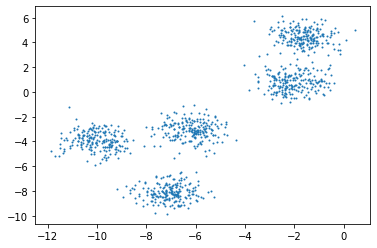

In [40]:
import numpy as np
from sklearn.datasets import make_blobs
from scipy.spatial.distance import pdist

import matplotlib.pyplot as plt

X, y = make_blobs(n_samples=1000, centers=5, cluster_std=0.7, random_state=1)
fig, ax = plt.subplots(figsize=(6,4), nrows=1)
ax.scatter(X[:,0], X[:,1], s=1)
plt.show()

### Que vamos a buscar?

* Grupos que me diferencien bien los distintos tipos de datos
* COHESION (distancia intra cluster)
* SEPARACION (Distancia entre clusteres)

## Clustering Jerárquico

### Presentación del problema

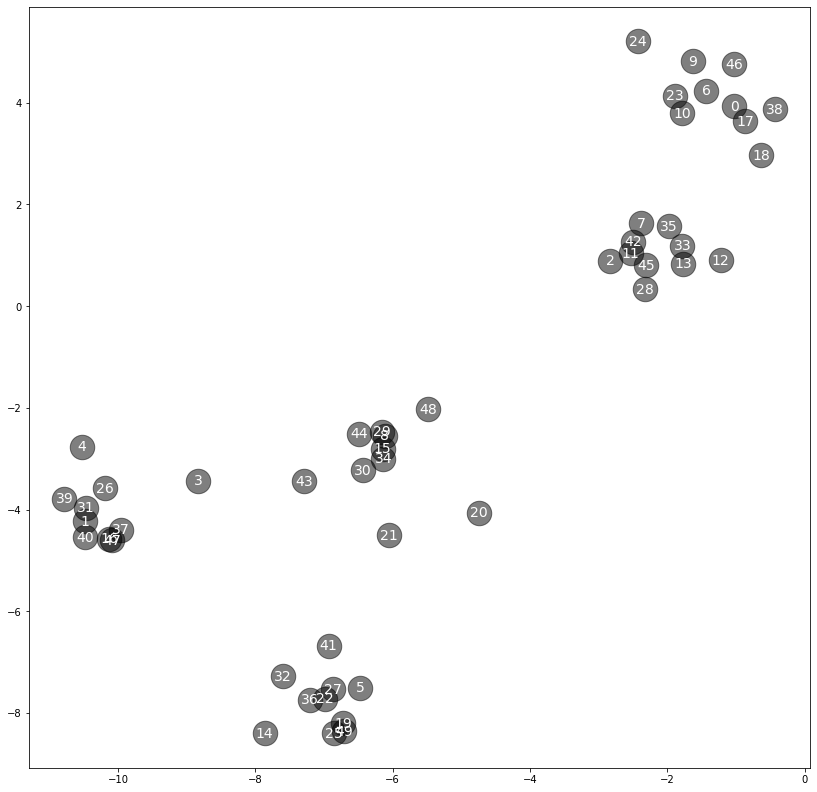

In [41]:
X, y = make_blobs(n_samples=50, centers=5, cluster_std=0.7, random_state=1)
fig, ax = plt.subplots(figsize=(14,14), nrows=1)
ax.scatter(X[:,0], X[:,1], s=600, c='k', alpha=0.5)

labels = range(len(X))
for label, x, y in zip(labels, X[:, 0], X[:, 1]):  
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points',
                 fontsize=14, ha='center', va='center', color='white')

plt.show()

In [42]:
X[1], X[31], X[39], X[40]

(array([-10.48187503,  -4.23107602]),
 array([-10.4675848 ,  -3.96221377]),
 array([-10.77982975,  -3.78925756]),
 array([-10.47873339,  -4.5449925 ]))

In [43]:
pdist((X[1],X[40])), pdist((X[39],X[31]))

(array([0.3139322]), array([0.35694644]))

In [44]:
pdist((X[1],X[39])), pdist((X[40],X[31]))

(array([0.53289827]), array([0.58288536]))

In [45]:
pdist((X[3],X[43])), pdist((X[3],X[26]))

(array([1.55019615]), array([1.35749508]))

In [46]:
X[:10]

array([[ -1.02896074,   3.92788037],
       [-10.48187503,  -4.23107602],
       [ -2.83108881,   0.89490238],
       [ -8.83585098,  -3.43391763],
       [-10.52072331,  -2.76863033],
       [ -6.47759379,  -7.50145665],
       [ -1.43623254,   4.23193061],
       [ -2.37764051,   1.63349007],
       [ -6.11372946,  -2.55537763],
       [ -1.63001028,   4.81446052]])

## Distancias en diferentes geometrías

### Euclidea

$$ {\displaystyle d(\mathbf {p} ,\mathbf {q} ) = {\sqrt {(p_{1}-q_{1})^{2}+(p_{2}-q_{2})^{2}+\cdots +(p_{n}-q_{n})^{2}}}={\sqrt {\sum _{i=1}^{n}(p_{i}-q_{i})^{2}}}} $$

### Canberra

$$ d(\mathbf {p} ,\mathbf {q} )=\sum _{i=1}^{n}{\frac {|p_{i}-q_{i}|}{|p_{i}|+|q_{i}|}} $$

### Chebyshev

$$ {\displaystyle d(\mathbf {p} ,\mathbf {q} ) = \max _{i}(|p_{i}-q_{i}|) } $$

### cityblock geometry (Manhattan)

$$ d(\mathbf {p} ,\mathbf {q} )=\sum _{i=1}^{n}|p_{i}-q_{i}| $$

### Geometrías no euclideas

<img src='imagenes/noneuclid_ex.jpg' width='400'>

In [47]:
from scipy.spatial.distance import pdist

puntos = ((-1,-2),(3,1))

tipos = ['euclidean', 'canberra', 'chebyshev', 'cityblock']
distancias = [pdist(puntos, metric=tipo)  for tipo in tipos]

dict(zip(tipos, distancias))

{'euclidean': array([5.]),
 'canberra': array([2.]),
 'chebyshev': array([4.]),
 'cityblock': array([7.])}

In [48]:
from scipy.spatial.distance import pdist

puntos = ((1,2),(5,5))

tipos = ['euclidean', 'canberra', 'chebyshev', 'cityblock']
distancias = [pdist(puntos, metric=tipo)  for tipo in tipos]

dict(zip(tipos, distancias))

{'euclidean': array([5.]),
 'canberra': array([1.0952381]),
 'chebyshev': array([4.]),
 'cityblock': array([7.])}

In [49]:
puntos = ((1,2),(6,2))

tipos = ['euclidean', 'canberra', 'chebyshev', 'cityblock']
distancias = [pdist(puntos, metric=tipo)  for tipo in tipos]

dict(zip(tipos, distancias))

{'euclidean': array([5.]),
 'canberra': array([0.71428571]),
 'chebyshev': array([5.]),
 'cityblock': array([5.])}

## Dendrogramas

### Euclideo: distancias mínimas

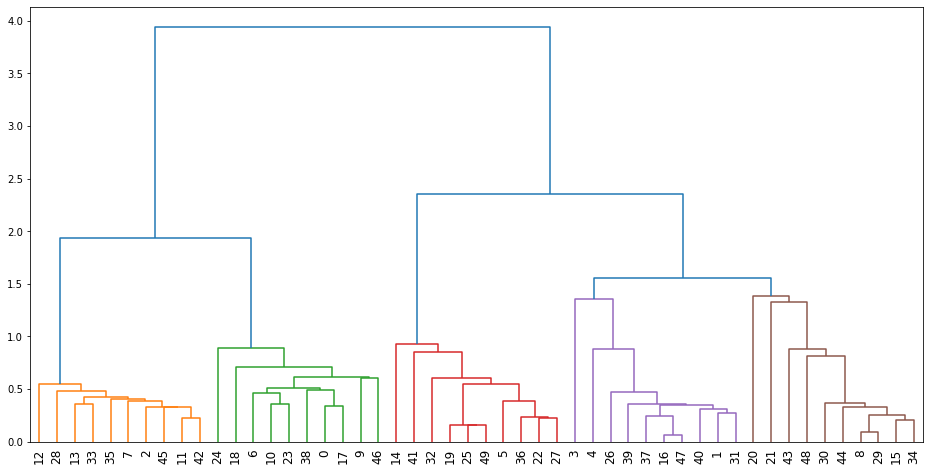

In [50]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

agrupados = linkage(X, 'single', metric='euclidean')

labelList = range(len(X))

plt.figure(figsize=(16, 8))  

dendrogram(agrupados, labels=labelList, leaf_font_size=12, color_threshold=1.5)

plt.show()  

### Euclideo: distancias máximas

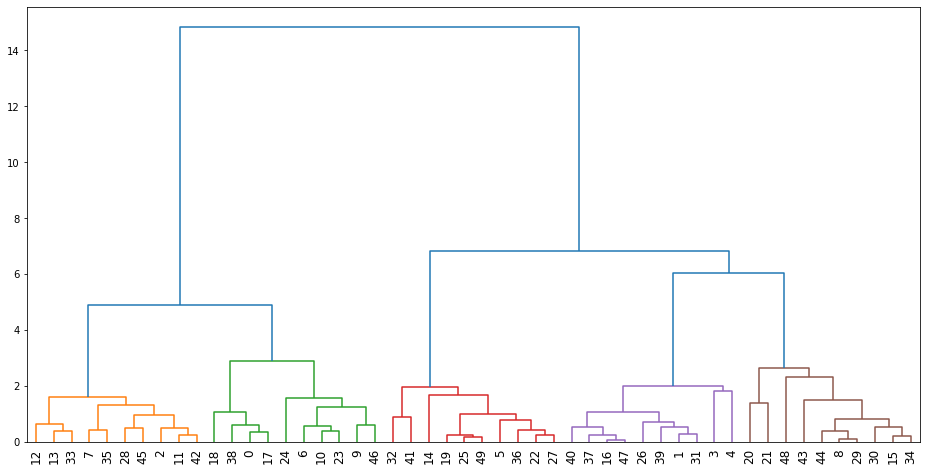

In [51]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

agrupados = linkage(X, 'complete', metric='euclidean')

labelList = range(len(X))

plt.figure(figsize=(16, 8))  

dendrogram(agrupados, labels=labelList, leaf_font_size=12, color_threshold=3)

plt.show()  

### Euclideo: Por varianzas

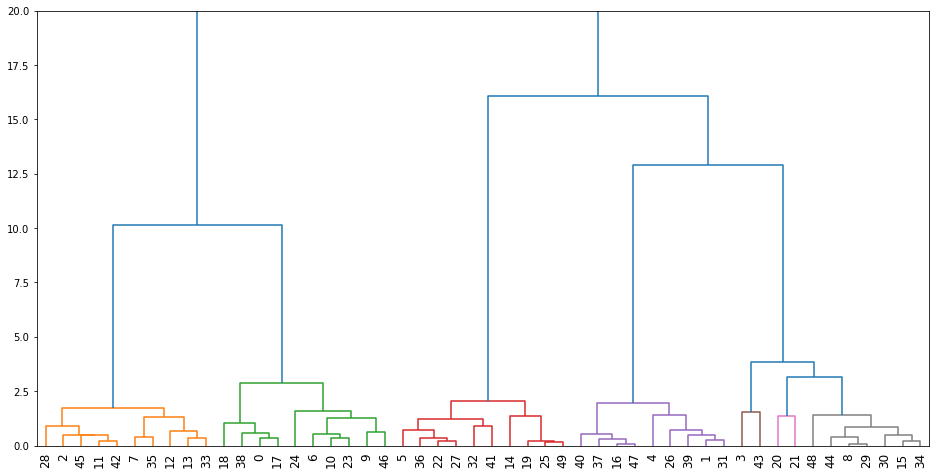

In [52]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,8))
agrupados = linkage(X, 'ward', metric='euclidean')

labelList = range(len(X))

dendrogram(agrupados, labels=labelList, leaf_font_size=12, color_threshold=3, ax=ax)
ax.set_ylim(0,20)

plt.show()  

### Espacio Geométrico: Canberra

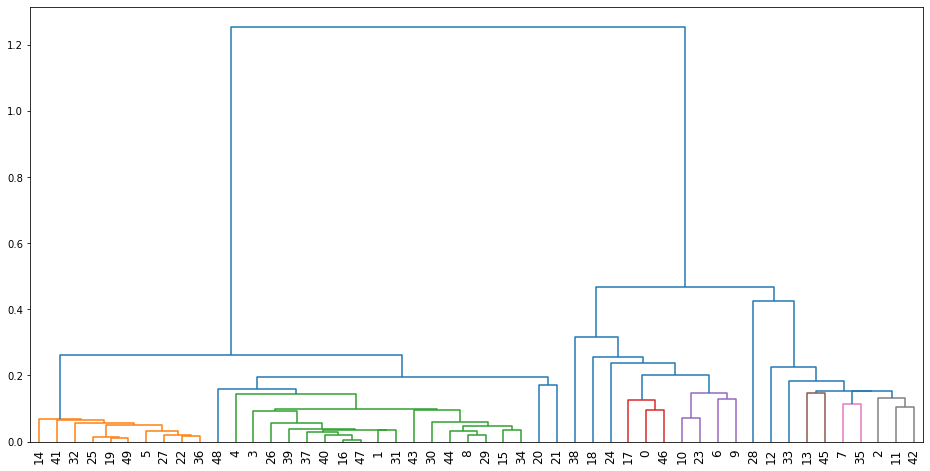

In [53]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

agrupados = linkage(X, 'single', metric='canberra')

labelList = range(len(X))

plt.figure(figsize=(16, 8))  

dendrogram(agrupados, labels=labelList, leaf_font_size=12, color_threshold=0.15)

plt.show()  

## Del dendograma a los clusters

In [54]:
X, y = make_blobs(n_samples=50, centers=5, cluster_std=0.7, random_state=1)
agrupados = linkage(X, 'single', metric='euclidean')
clusters = fcluster(agrupados, t=1.5, criterion='distance')
clusters

array([2, 4, 1, 4, 4, 3, 2, 1, 5, 2, 2, 1, 1, 1, 3, 5, 4, 2, 2, 3, 5, 5,
       3, 2, 2, 3, 4, 3, 1, 5, 5, 4, 3, 1, 5, 1, 3, 4, 2, 4, 4, 3, 1, 5,
       5, 1, 2, 4, 5, 3], dtype=int32)

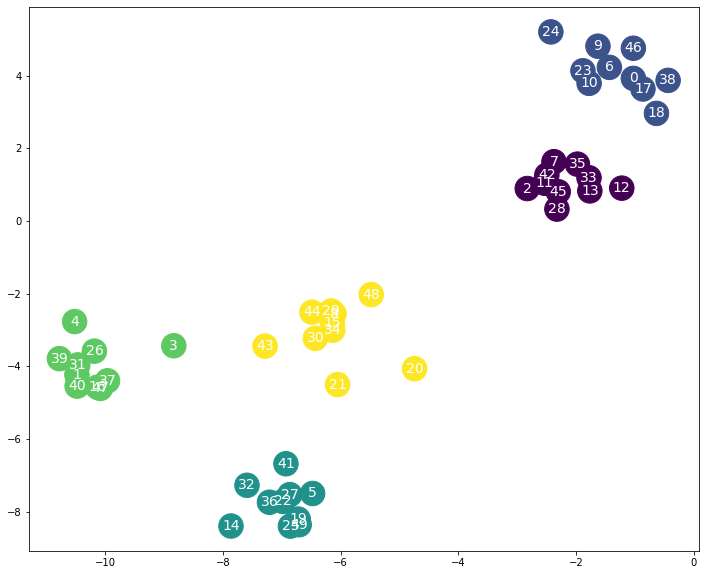

In [55]:
X, y = make_blobs(n_samples=50, centers=5, cluster_std=0.7, random_state=1)
fig, ax = plt.subplots(figsize=(12,10), nrows=1)
ax.scatter(X[:,0], X[:,1], s=600, c=clusters, alpha=1)

labels = range(len(X))
for label, x, y in zip(labels, X[:, 0], X[:, 1]):  
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points',
                 fontsize=14, ha='center', va='center', color='white')

plt.show()

## ¿Dónde es útil la clusterización jerárquica?

* Segmentacion de clientes
* Busqueda de nichos de mercado
* Busqueda de fraudes
* Busqueda de grupos similares en general en conjuntos de hasta 10k datos 


Hasta 10k conglomerados iniciales (cantidad de datos inicial), es muy eficiente este algoritmo, mas de esa cantidad empieza a ser ineficiente y conviene migrar a otro tipo de algoritmo

## Aplicación Real de clustering jerárquico

### API FMP - Obtención de datos

Sitio de FMP API:  https://fmpcloud.io/ 

* ETFs (424)
* Commodities (28)
* Equity Europa: Euronext (1248)
* Equity Nyse (4380)
* Equity Amex (274)
* Equity Nasdaq (3825)
* Equity Canadá: TSX (1413)
* Indices (56)
* Fondos Mutuales (1504)

In [56]:
# apikey = '66c44b016256f8b9e507838f32434ece'
apikey = '40512dde086b01e979adf6e14cd55ec3' # saquen la suya..
apikey = '66c44b016256f8b9e507838f32434ece'

import requests
import pandas as pd

def screenMktCapHigh(minMktCap= 10**10):
    url = 'https://fmpcloud.io/api/v3/stock-screener'
    p = {'apikey': apikey, 'marketCapMoreThan':minMktCap }
    r = requests.get(url, params = p)
    js = r.json()
    df = pd.DataFrame(js)
    return df

data = screenMktCapHigh().drop('companyName', axis=1)
data.iloc[:,:-4]

,symbol,marketCap,sector,industry,beta,price,lastAnnualDividend,volume,exchange
0,SAISX,1534332510000000,,,0.000000,24.58,0.426000,0,Nasdaq Capital Market
1,AAPL,2249154630000,Technology,Consumer Electronics,1.208152,134.78,0.835000,84175388,Nasdaq Global Select
2,MSFT,2023883540000,Technology,Software—Infrastructure,0.789130,268.72,2.190000,25470776,Nasdaq Global Select
3,MSF.BR,2020720250000,Technology,Software—Infrastructure,0.794263,268.30,2.190000,174,Brussels
4,AMZN,1736836380000,Consumer Cyclical,Internet Retail,1.151630,3443.89,0.000000,3498738,Nasdaq Global Select
...,...,...,...,...,...,...,...,...,...
1523,HUBB,10034393100,Industrials,Electrical Equipment & Parts,1.185869,184.74,3.850000,226969,New York Stock Exchange
1524,PLTK,10031202300,Communication Services,Electronic Gaming & Multimedia,0.000000,24.49,0.000000,983268,Nasdaq Global Select
1525,RHI,10030742500,Industrials,Staffing & Employment Services,1.575543,88.94,1.440000,855346,New York Stock Exchange
1526,CMA,10015836200,Financial Services,Banks—Regional,1.640217,71.74,2.720000,1507485,New York Stock Exchange


In [57]:
data.groupby('exchangeShortName').size()

exchangeShortName
AMEX             3
ETF              5
EURONEXT       137
MUTUAL_FUND    140
NASDAQ         357
NYSE           787
TSX             99
dtype: int64

In [58]:
data['div_yield'] = data['lastAnnualDividend'] / data['price']
data['vol_mln'] = data['price'] * data['volume'] / 1000000

df = data.loc[(data.exchangeShortName=='NASDAQ') |  (data.exchangeShortName=='NYSE')].reset_index().copy()
df = df.loc[:100,['symbol','marketCap','beta','div_yield','vol_mln']]
df

,symbol,marketCap,beta,div_yield,vol_mln
0,AAPL,2249154630000,1.208152,0.006195,11345.158795
1,MSFT,2023883540000,0.789130,0.008150,6844.506927
2,AMZN,1736836380000,1.151630,0.000000,12049.268811
3,GOOGL,1671425430000,0.995587,0.000000,3638.446744
4,GOOG,1668741600000,1.017391,0.000000,3367.986044
...,...,...,...,...,...
96,RIO,136738202000,0.594684,0.065948,214.063701
97,LOW,136578220000,1.341304,0.012163,775.291255
98,CHTR,136096104000,0.982065,0.000000,637.322281
99,ASAX,135998710000,0.000000,0.000000,0.137743


### Praparamos datos para Clusterizacion

In [59]:
data = screenMktCapHigh()
data['div_yield'] = data['lastAnnualDividend'] / data['price']
data['vol_mln'] = data['price'] * data['volume'] / 1000000

df = data.loc[(data.exchangeShortName=='NASDAQ') |  (data.exchangeShortName=='NYSE')].copy().reset_index()
df = df.loc[:75,['symbol','marketCap','beta','div_yield','vol_mln']]
df

,symbol,marketCap,beta,div_yield,vol_mln
0,AAPL,2249154630000,1.208152,0.006195,11345.158795
1,MSFT,2023883540000,0.789130,0.008150,6844.506927
2,AMZN,1736836380000,1.151630,0.000000,12049.268811
3,GOOGL,1671425430000,0.995587,0.000000,3638.446744
4,GOOG,1668741600000,1.017391,0.000000,3367.986044
...,...,...,...,...,...
71,MS,163173728000,1.548913,0.015964,898.603930
72,AZN,157716185000,0.212824,0.023306,484.650046
73,QCOM,157604168000,1.341304,0.018823,1225.503541
74,RDS-A,157514695000,0.990602,0.024436,215.374783


In [60]:
valores = df.iloc[:,[1,2,3,4]].values
valores[:5]

array([[2.24915463e+12, 1.20815200e+00, 6.19528120e-03, 1.13451588e+04],
       [2.02388354e+12, 7.89130000e-01, 8.14974695e-03, 6.84450693e+03],
       [1.73683638e+12, 1.15163000e+00, 0.00000000e+00, 1.20492688e+04],
       [1.67142543e+12, 9.95587000e-01, 0.00000000e+00, 3.63844674e+03],
       [1.66874160e+12, 1.01739100e+00, 0.00000000e+00, 3.36798604e+03]])

### Escalamos

In [61]:
from sklearn.preprocessing import StandardScaler
escalar = StandardScaler()

valores_esc = escalar.fit_transform(valores)
print(valores_esc[:5])

[[ 4.37679363  0.90243296 -0.63018512  2.0711313 ]
 [ 3.84513065 -0.09396406 -0.51441102  1.05737058]
 [ 3.16766979  0.76802868 -0.99716682  2.22973034]
 [ 3.01329321  0.39697231 -0.99716682  0.33521344]
 [ 3.00695909  0.44882028 -0.99716682  0.27429283]]


### Armamos Dendograma

In [62]:
%matplotlib inline

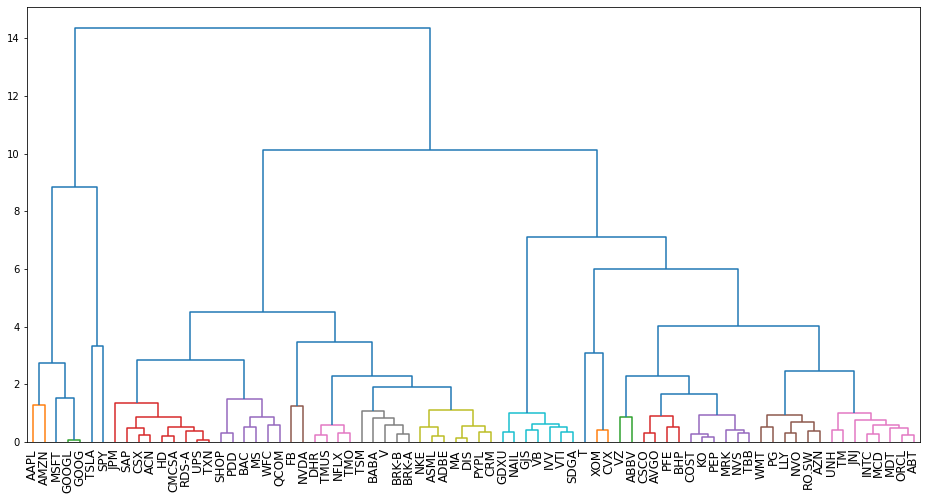

In [63]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Algunas configs similares method/t: ward/1,5, average/0,8, weighted/0.7, median/0.7
# metodos: ward, single, median, centroid, weighted, complete, average

clusterizado = linkage(valores_esc, method = 'ward')
labels = df.iloc[:,0].values

fig, ax = plt.subplots(figsize=(16, 8))  
dendrogram(clusterizado, labels=labels, color_threshold=1.5, leaf_font_size=12, ax=ax)
#ax.set_ylim(0,8)
plt.show() 

### Asignamos clusteres a partir de dendograma

In [64]:
clusters = fcluster(clusterizado, t=1.5, criterion='distance')
clusters

array([ 1,  3,  1,  2,  2,  8,  4, 10, 10, 10, 10, 10,  8,  6, 12, 19,  5,
       18, 19, 11,  7, 11, 12, 12,  6, 18, 11, 18, 11, 12, 11, 12, 13,  6,
       19, 11,  9, 17, 15, 19, 11, 16, 19, 16, 18,  6, 17, 14, 19, 17, 13,
       15, 12,  9, 17, 16,  9, 18, 12,  7,  6,  7, 16,  9,  6,  6, 17, 19,
        6, 19, 17,  7, 18,  7,  6,  7], dtype=int32)

<AxesSubplot:xlabel='cluster'>

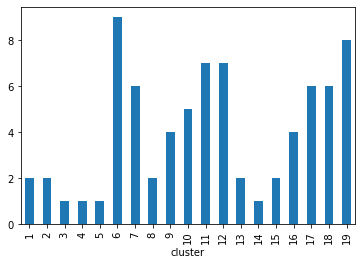

In [65]:
df['cluster']  = clusters
df.groupby('cluster').size().plot(kind='bar')

In [66]:
df.head(15)

,symbol,marketCap,beta,div_yield,vol_mln,cluster
0,AAPL,2249154630000,1.208152,0.006195,11345.158795,1
1,MSFT,2023883540000,0.789130,0.008150,6844.506927,3
2,AMZN,1736836380000,1.151630,0.000000,12049.268811,1
3,GOOGL,1671425430000,0.995587,0.000000,3638.446744,2
4,GOOG,1668741600000,1.017391,0.000000,3367.986044,2
5,FB,1008403090000,1.300000,0.000000,6280.047246,8
6,TSLA,663464570000,1.995108,0.000000,20410.266099,4
7,BRK-B,632629170000,0.904347,0.000000,1304.140082,10
8,BRK-A,632378290000,0.904347,0.000000,15.819552,10
9,TSM,620307020000,1.010199,0.014782,1071.253115,10


### Implementamos los Clusteres en la matriz escalada para reporting grafico

In [67]:
df_esc = pd.DataFrame(valores_esc)
df_esc.columns=df.columns[1:-1]
df_esc['cluster'] = clusters
df_esc['simbolo'] = labels

cantidades = df_esc.groupby('cluster').size()
clusteres_grandes = list(cantidades.sort_values(ascending=False).index)[:8]
clusteres_grandes

[6, 19, 12, 11, 17, 7, 18, 10]

### Reporte Visual del clusterizado

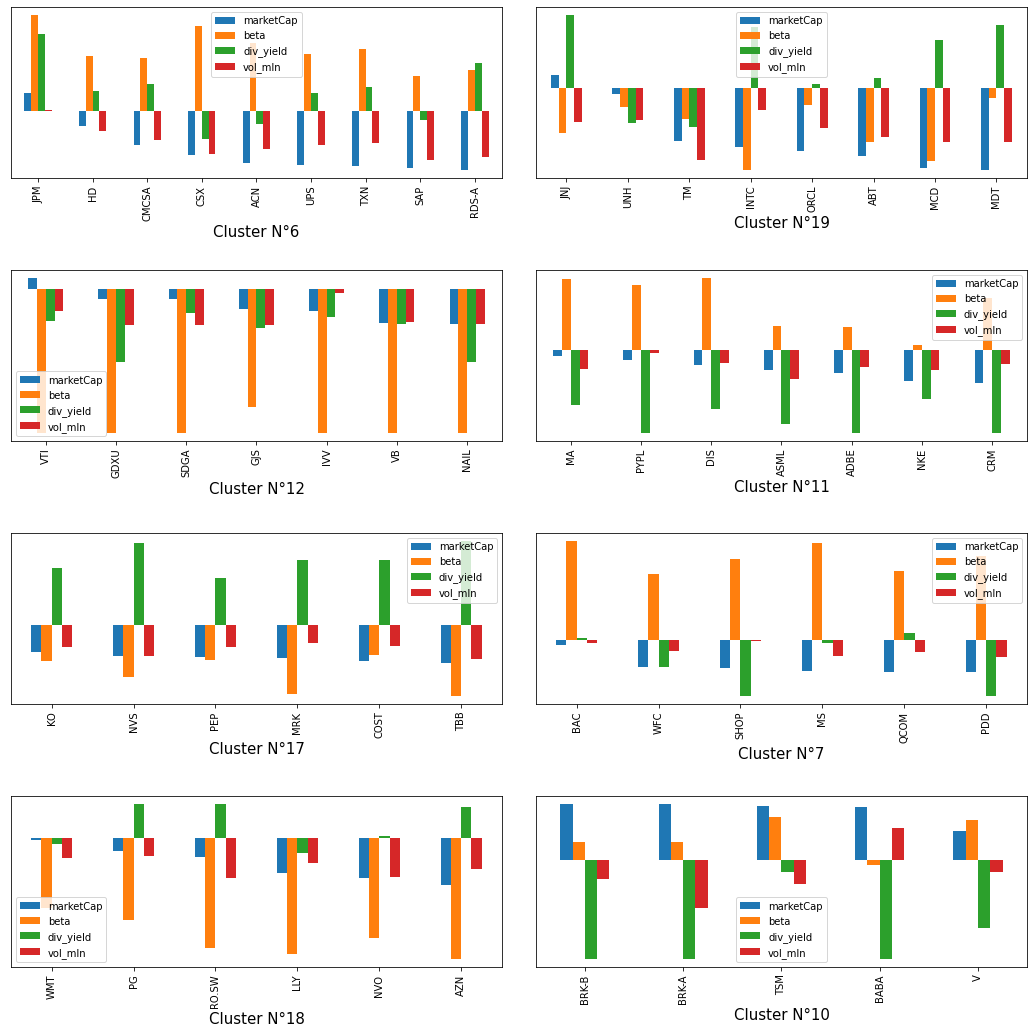

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline

columnas = 2
fig, ax = plt.subplots(figsize=(15,15), ncols=columnas, nrows=4)

for i in range(len(clusteres_grandes)):
    col = i % columnas
    row = i // columnas    
    cluster = clusteres_grandes[i]
    grupo = df_esc.loc[df_esc.cluster==cluster].drop(['cluster'], axis=1).set_index('simbolo')
    grupo.plot(kind='bar', ax=ax[row][col])
    ax[row][col].axes.yaxis.set_visible(False)
    ax[row][col].set_xlabel('Cluster N°'+str(cluster), fontsize=15)

fig.tight_layout(pad=3.0)
plt.show()

### Reporte cuantitativo del clusterizado

In [69]:
cant = df.groupby('cluster').size()
medias = df.groupby('cluster').mean()
medias['cantidades'] = cant
medias = medias.sort_values('cantidades', ascending=False)
medias

,marketCap,beta,div_yield,vol_mln,cantidades
cluster,,,,,
6,2.381464e+11,1.072365,0.019755,803.152293,9
19,2.567621e+11,0.715018,0.019406,851.696882,8
11,2.964626e+11,1.054929,0.002825,1291.231706,7
12,2.970590e+11,0.022029,0.006845,416.730968,7
18,2.643995e+11,0.322464,0.019697,612.874624,6
17,1.965668e+11,0.533323,0.032948,581.433766,6
7,2.013834e+11,1.444874,0.010141,1370.193886,6
10,6.040899e+11,0.924104,0.004033,1511.760697,5
9,2.023752e+11,0.682535,0.001193,1095.051216,4


# Ejemplo clusterizacion un poco mas grande

In [70]:
data = screenMktCapHigh()
data

,symbol,companyName,marketCap,sector,industry,beta,price,lastAnnualDividend,volume,exchange,exchangeShortName,country,isEtf,isActivelyTrading
0,SAISX,SA International Small Company Fund Investor C...,1534332510000000,,,0.000000,24.58,0.426000,0,Nasdaq Capital Market,MUTUAL_FUND,US,False,True
1,AAPL,Apple Inc.,2249154630000,Technology,Consumer Electronics,1.208152,134.78,0.835000,84175388,Nasdaq Global Select,NASDAQ,US,False,True
2,MSFT,Microsoft Corporation,2023883540000,Technology,Software—Infrastructure,0.789130,268.72,2.190000,25470776,Nasdaq Global Select,NASDAQ,US,False,True
3,MSF.BR,Microsoft Corporation,2020720250000,Technology,Software—Infrastructure,0.794263,268.30,2.190000,174,Brussels,EURONEXT,US,False,True
4,AMZN,"Amazon.com, Inc.",1736836380000,Consumer Cyclical,Internet Retail,1.151630,3443.89,0.000000,3498738,Nasdaq Global Select,NASDAQ,US,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1523,HUBB,Hubbell Incorporated,10034393100,Industrials,Electrical Equipment & Parts,1.185869,184.74,3.850000,226969,New York Stock Exchange,NYSE,US,False,True
1524,PLTK,Playtika Holding Corp.,10031202300,Communication Services,Electronic Gaming & Multimedia,0.000000,24.49,0.000000,983268,Nasdaq Global Select,NASDAQ,IL,False,True
1525,RHI,Robert Half International Inc.,10030742500,Industrials,Staffing & Employment Services,1.575543,88.94,1.440000,855346,New York Stock Exchange,NYSE,US,False,True
1526,CMA,Comerica Incorporated,10015836200,Financial Services,Banks—Regional,1.640217,71.74,2.720000,1507485,New York Stock Exchange,NYSE,US,False,True


In [71]:
data = screenMktCapHigh()
data['div_yield'] = data['lastAnnualDividend'] / data['price']
data['vol_mln'] = data['price'] * data['volume'] / 1000000

df = data.loc[(data.exchangeShortName=='NASDAQ') |  (data.exchangeShortName=='NYSE')].copy().reset_index()
df = df.loc[:500,['symbol','marketCap','beta','div_yield','vol_mln']]

valores = df.iloc[:,[1,2,3,4]].values
valores_esc = StandardScaler().fit_transform(valores)
clusterizado = linkage(valores_esc, method = 'ward')
clusters = fcluster(clusterizado, t=1.5, criterion='distance')
df['cluster']  = clusters

df_esc = pd.DataFrame(valores_esc)
df_esc.columns=df.columns[1:-1]
df_esc['cluster'] = clusters
df_esc['simbolo'] = df.iloc[:,0].values

cantidades = df_esc.groupby('cluster').size()
clusteres_grandes = list(cantidades.sort_values(ascending=False).index)[:8]
clusteres_grandes

[39, 38, 50, 47, 33, 28, 32, 18]

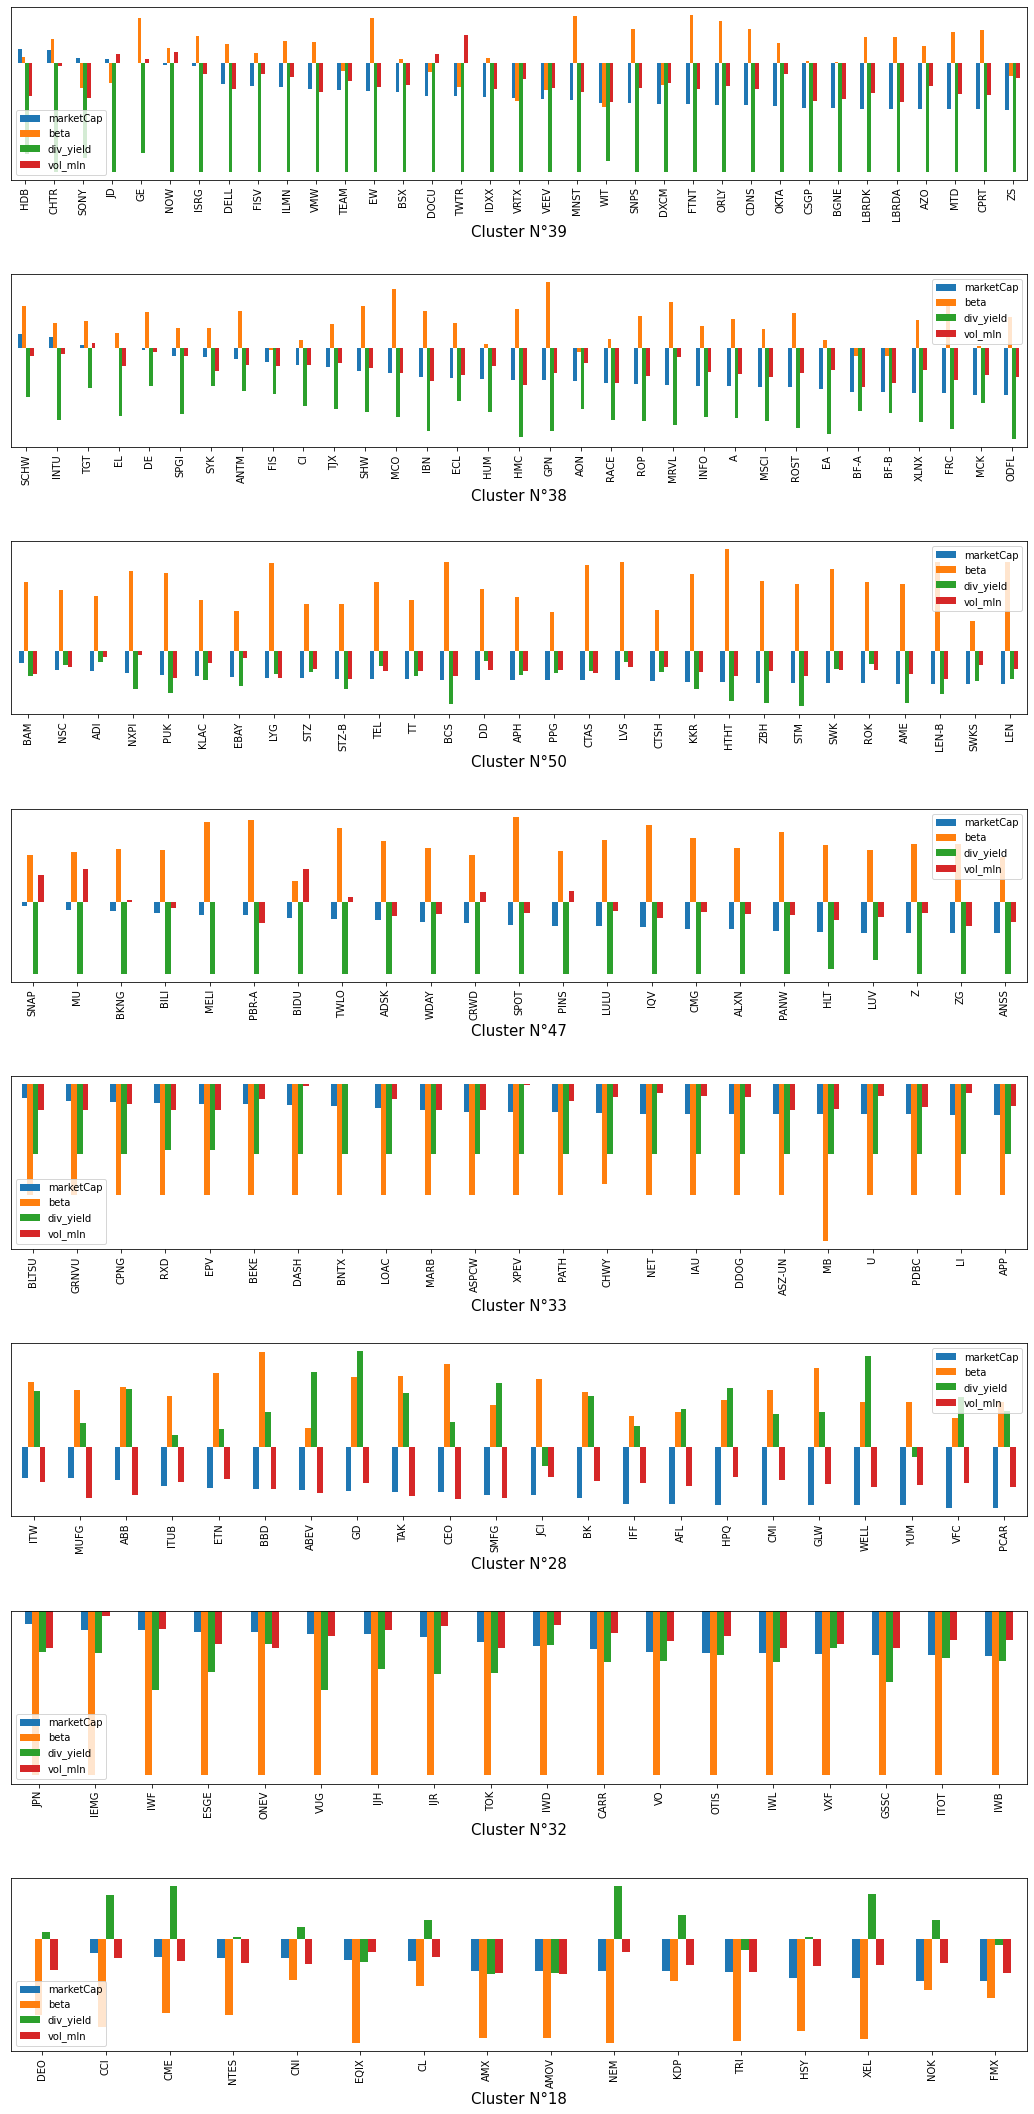

In [72]:
columnas = 1
fig, ax = plt.subplots(figsize=(15,30), nrows=len(clusteres_grandes))

for i in range(len(clusteres_grandes)):
    cluster = clusteres_grandes[i]
    grupo = df_esc.loc[df_esc.cluster==cluster].drop(['cluster'], axis=1).set_index('simbolo')
    grupo.plot(kind='bar', ax=ax[i])
    ax[i].axes.yaxis.set_visible(False)
    ax[i].set_xlabel('Cluster N°'+str(cluster), fontsize=15)

fig.tight_layout(pad=3.0)
plt.show()

<AxesSubplot:xlabel='cluster'>

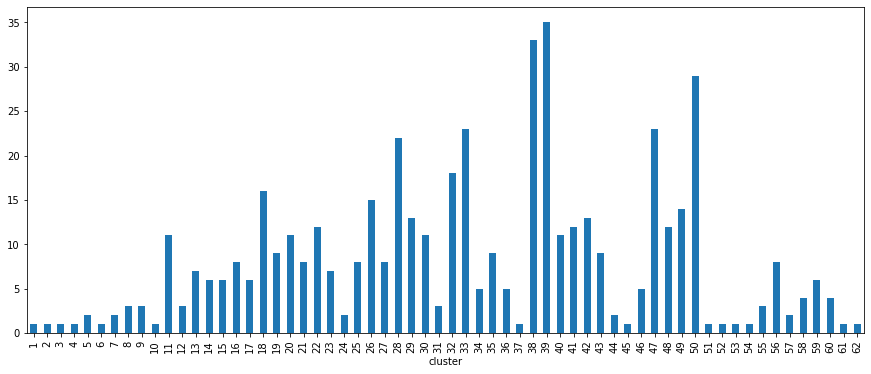

In [73]:
df.groupby('cluster').size().plot(kind='bar', figsize=(15,6))

In [74]:
df.groupby('cluster').mean().sort_values('beta')

,marketCap,beta,div_yield,vol_mln
cluster,,,,
37,1.145760e+11,-1.482678,0.000000,1229.679534
33,4.440085e+10,-0.012333,0.000103,243.575907
31,1.754832e+11,0.000000,0.002977,61.193376
32,5.401082e+10,0.000000,0.008846,190.938999
7,5.738822e+10,0.000000,0.112013,28.298824
...,...,...,...,...
1,6.634646e+11,1.995108,0.000000,20410.266099
24,3.718484e+10,2.233019,0.047680,192.261474
43,4.176857e+10,2.244482,0.006783,439.899917
